# HPC Mini-Challenge 2 - Beschleunigung in Data Science
#### FHNW - FS2024

Original von S. Suter, angepasst von S. Marcin und M. Stutz

### Ressourcen
* HPC mit Python – days 1-2 ([Videos](https://www.youtube.com/playlist?list=PL1tk5lGm7zvSC4rLm5Y71372R1Yxl2Dg_), [Github](https://github.com/eth-cscs/PythonHPC)), 2020:
    - JupyterLab Tutorial (z.B. GPU Ressourcen)
    - Introduction
    - Vectorization
    - Profiling
    - JIT Numba CPU 1 + 2
    - Siehe auch aktuelles Tutorial von 2021

Abgabe von: <font color='blue'>Tobias Buess</font>


## Ausgangslage/Problemstellung


Das menschliche Gehirn verliert mit zunehmendem Alter an Funktion. Ein Teil davon ist "gesundes Altern", d.h. es passiert bei jedem Menschen. Ein relativ großer Prozentsatz der alternden Bevölkerung erlebt jedoch auch einen kognitiven Rückgang, der extremer ist als bei anderen. Eine mildere Version davon wird als 'leichte kognitive Beeinträchtigung' (MCI) bezeichnet, bei der die Person grösstenteils noch funktionieren kann. Bei einem Teil der MCI-Patienten schreitet die Krankheit fort und führt zu Demenz bzw. Alzheimer. In diesem Projekt liegen uns MRI-Bilder des Gehirns von Alzheimerpatienten vor. Im spezifischen analysieren wir die Entwicklung von Alzheimer-Patienten anhand von MRI-Bildern, welche über eine bestimmte Zeit zur Verfügung stehen. Es stellt sich die Frage, wie gut sich die Veränderungen des Krankheitsbildes mittels Korrelationen über die Bildanalyse zeigen lassen. Zur Analyse sind Gigabytes von Daten in Form von 3D Gehirn-Scans vorhanden. Die Verarbeitung dieser grossen Datenmengen kann von Komprimierung profitieren.

Das Verständnis von Gedächtnis- und Kognitionsstörungen und die Möglichkeit, den Gesundheitszustand des Gehirns zu erkennen, vorherzusagen und zu überwachen, ist ein gesellschaftlich und wirtschaftlich relevantes Thema der angewandten Wissenschaft. Alle neuen Erkenntnisse, die datenwissenschaftliche Methoden liefern können, werden zur Entwicklung von Lösungen beitragen, mit denen die Gesundheit des Gehirns erkannt, vorhergesagt und überwacht werden kann.

### Daten
[ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/) ist ein internationales Projekt zur Erfassung von Daten über die Alzheimer-Krankheit und andere verwandte Gehirnerkrankungen, die zu einem kognitiven Abbau führen. Die Initiative wurde mit grossem Enthusiasmus aufgenommen, und viele Mitarbeiter aus der ganzen Welt haben Daten zur Verfügung gestellt, die sie in ihren eigenen Forschungsteams gesammelt haben. Die ADNI-Initiative ist ein öffentliches (gemeinnütziges) Projekt, da viele Forschungseinrichtungen auf der ganzen Welt mit Steuergeldern dazu beigetragen haben. Das bedeutet zwei Dinge: Die Daten stehen uns zwar für Forschungs- und Bildungszwecke zur Verfügung, aber wir dürfen die Daten **nicht** an andere weitergeben oder kommerzialisieren.



***Wichtig!*** Die Studierenden dürfen die Daten nur für Forschungszwecke verwenden und erhalten nur einen Beispielsdatensatz. Die ADNI-Daten dürfen nur lokal auf dem Computer oder auf FHNW-Ressourcen wie dem GitLab-Repository, d.h. nicht auf Github, gespeichert werden. Siehe [ADNI Datennutzungsvereinbarung](https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf).


<img src="images/mri-example.png" alt="MRI example image (coronal slice)" width="150"/> <img src="images/slicing.png" alt="Slicing" width="400"/>

Links: MRI Beispielbild (coronaler Schnitt), rechts: MRI slicing

## Zielsetzung

In dieser Aufgabe sollen die Parallelisierung und Beschleunigung unterschiedlicher Methoden von Bildrekonstruktion basierend auf komprimierten (zerlegten) Daten implementiert, analyisiert und diskutiert werden. Die Rekonstruktion der Daten aus der komprimierten Version soll dabei möglichst in Echtzeit geschehen. 

## Lösungsweg / Vorgehen

Wir lösen diese Aufgabenstellung indem wir die Singulärwertzerlegung (SVD: singular value decomposition) als Kompressionsmethode verwenden (Matrixfaktorisierung). Siehe Abbildungen unten. Um die Rekonstruktion der Daten aus der SVD-Matrixfaktoriseriung möglichst in Echtzeit zu bewerkstelligen, evaluieren wir dafür verschiedene Methoden der Parallelisierung und Beschleunigung in Python. 
* Beschleunigungsvarianten auf der CPU:
    - Numpy Operationen inkl. Broadcasting
    - Numba
    - Threads
* Beschleunigung auf der GPU:
    - Cupy (analog zu Numpy)
    - Numba (analog zu Numba)

<img src="images/svd_reco.png" alt="svd vis" width="300"/> <img src="images/svd.png" alt="svd" width="300"/>

## Daten Zerlegen
### 1.1 Daten laden


In [48]:
import os
import imageio.v3 as imageio
import numpy as np
import glob

subfolder = '001'
folders = os.path.join('adni_png', subfolder)

# Get all PNGs from 001 with 145 in the name
files = sorted(glob.glob(f"{folders}/*145.png"))

# Load all images using ImageIO and create a numpy array from them
images = np.array([imageio.imread(f) for f in files])

# Get all the names of the files
names = [f[-17:-4] for f in files]

print(images.shape)

(7, 256, 170)


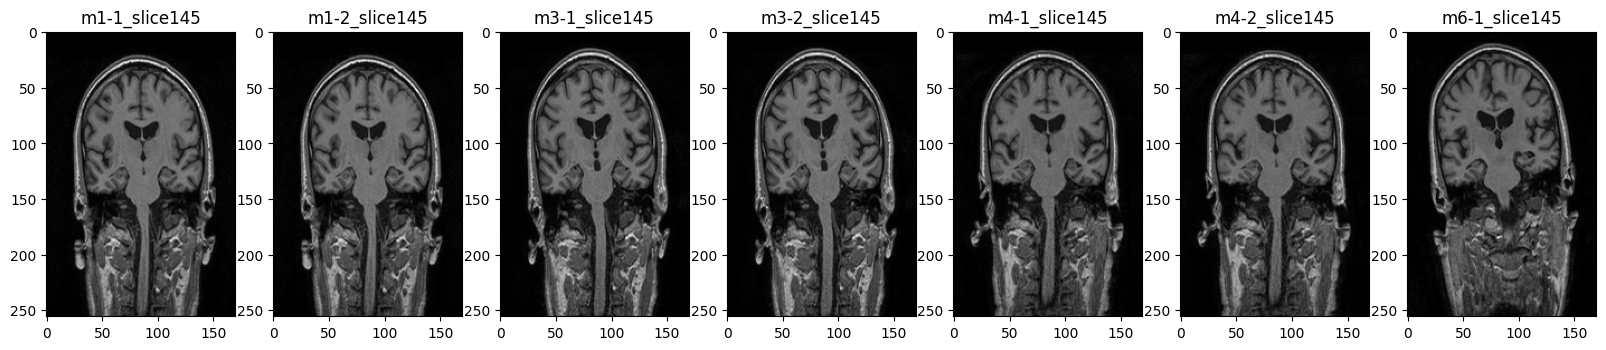

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,10))

for a in range(images.shape[0]):
    ax = fig.add_subplot(1,images.shape[0],a+1)
    ax.imshow(images[a],cmap='gray')
    ax.set_title(names[a])


### 1.2 Daten zerlegen

In [50]:
def reconstruct_svd(u,s,vt,k):
    """SVD reconstruction for k components using np.dot()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
        
    return reco

In [51]:
from skimage import metrics

# calculate various metrics for the reconstruction quality
def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    ssim_score = metrics.structural_similarity(im, reco, data_range=1)
    hdist = metrics.hausdorff_distance(im, reco)
    return f"MSE: {mse:.2f}, SSIM {ssim_score:.2f}, HDIST: {hdist:.2f}"


original size:  43520
decomposed to n =  170 , size:  72590
decomposed to n =  140 , size:  59780
decomposed to n =  110 , size:  46970
decomposed to n =  80 , size:  34160
decomposed to n =  50 , size:  21350


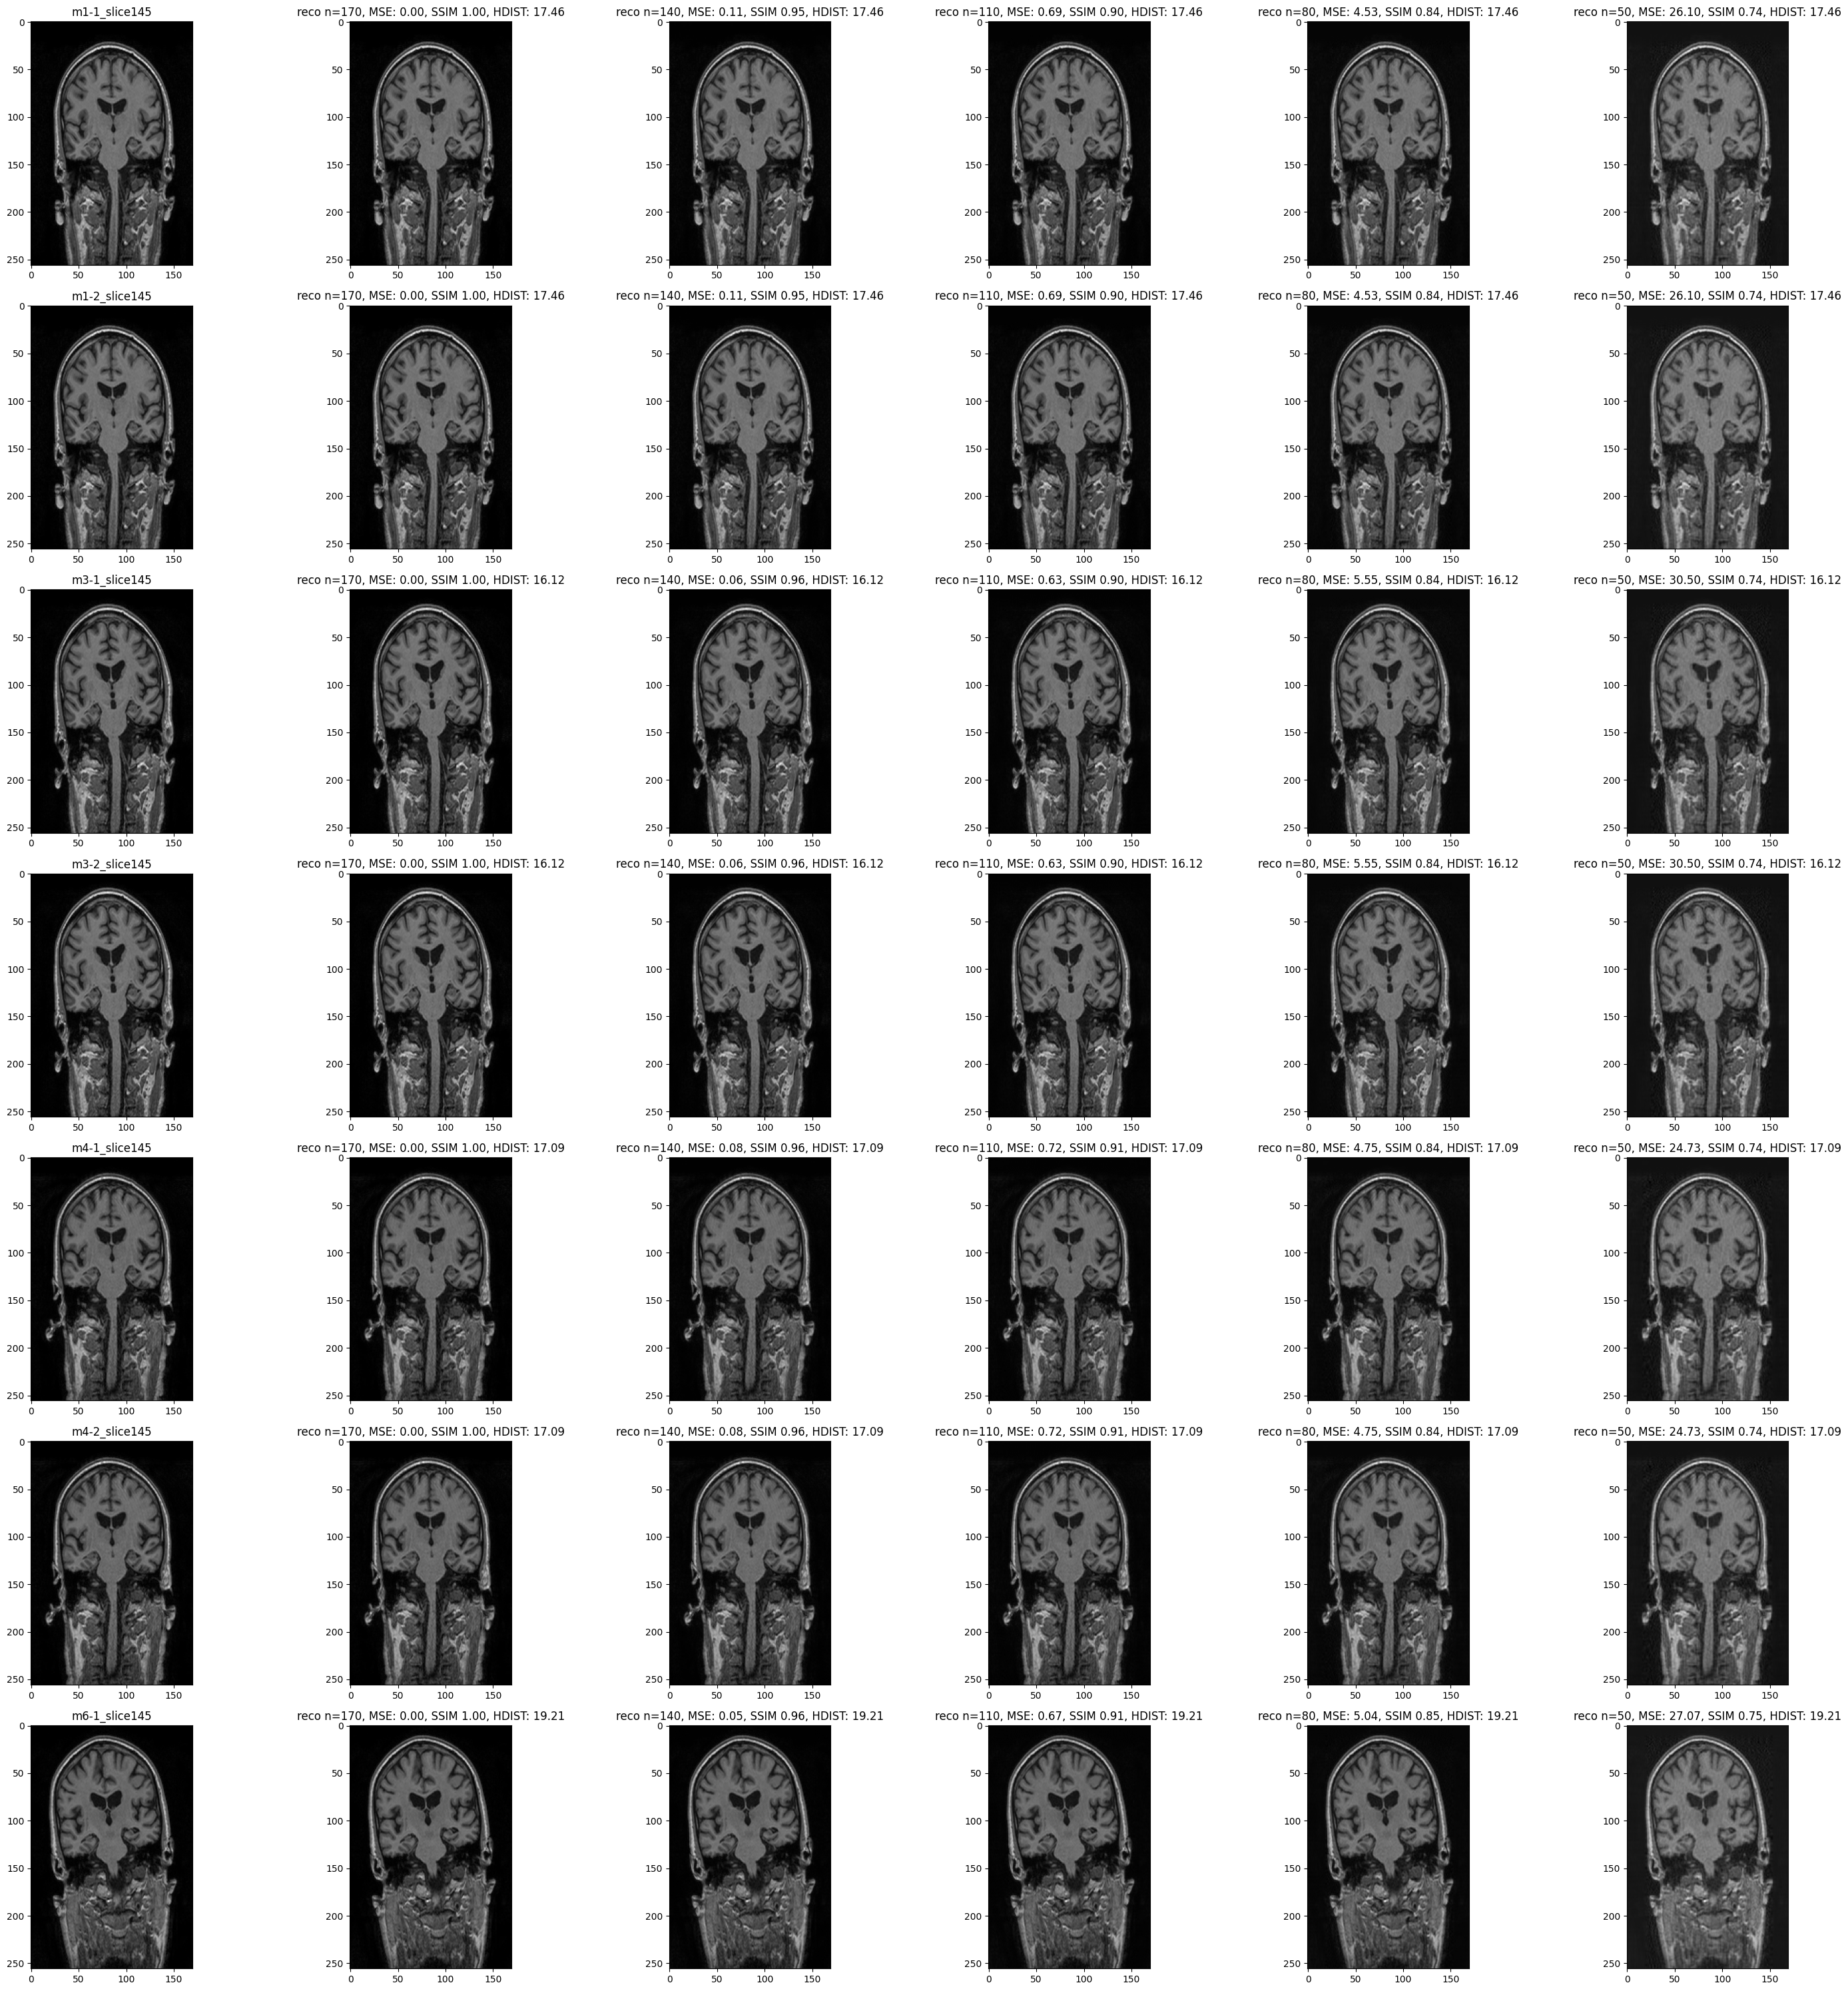

In [52]:
fig, axs = plt.subplots(images.shape[0], 6, figsize=(30,30))

for a in range(images.shape[0]):
    im = images[a]
    im = im - im.min() / im.max() - im.min()  # normalize image
    u, s, vt = np.linalg.svd(im, full_matrices=False)

    axs[a, 0].imshow(im,cmap='gray')
    axs[a, 0].set_title(names[a])
    
    if (a == 0):
        print('original size: ', im.shape[0]*im.shape[1])
    
    for idx, n in enumerate(range(s.shape[0], 20, -30)):
        reco = reconstruct_svd(u,s,vt,n)
        if (a == 0):
            print('decomposed to n = ', n , ', size: ', u.shape[0] * n + n + vt.shape[0]*n)
    
        axs[a, idx+1].imshow(reco,cmap='gray')
        axs[a, idx+1].set_title('reco n=' + str(n) + ', ' + calculate_metrics(im, reco))
plt.tight_layout()


### 2 Rekonstruktionsvarianten
Siehe Bilder in der Einführung (Teil: Vorgehen).

In [53]:
# helper function to visualze reconstruction
def plot_reco(reco, k):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')

#### 2.1 For-Loops
Rekonstruiere nun die zerlegte SVD Matrix mittels For-Loops gemäss Formel B.4 (oben). Rekonstruiere nur die ersten $k$ Komponenten der SVD-Matrixfaktorisierung $U, S, V^T$, wobei $U \in \mathbb{R}^{MxN}$, $S \in \mathbb{R}^{N}$, und  $V^T \in \mathbb{R}^{NxN}$. 

Implementiere dafür folgende drei Funktionen - jeweils mit 3, 2 bzw. 1 For-Loop:

In [54]:
def reconstruct_svd_for_loops3(u,s,vt,k):
    """SVD reconstruction for k components using 3 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION

    if k is None:
        k = min(u.shape[0], vt.shape[0])

    reco = np.zeros((u.shape[0], vt.shape[0]))

    for m in range(u.shape[0]):
        for n in range(vt.shape[0]):
            element = 0
            for p in range(k):
                element += u[m, p]*s[p]*vt[p, n]

            reco[m, n] = element
            
    ### END SOLUTION

    return reco

In [55]:
def reconstruct_svd_for_loops2(u,s,vt,k):
    """SVD reconstruction for k components using 2 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    if k is None:
        k = min(u.shape[0], vt.shape[0])

    reco = np.zeros((u.shape[0], vt.shape[0]))

    for m in range(u.shape[0]):
        for n in range(vt.shape[0]):
            reco[m, n] = np.sum(u[m, :k]*s[:k]*vt[:k, n])
            
    ### END SOLUTION

    return reco

In [56]:
def reconstruct_svd_for_loops1(u,s,vt,k):
    """SVD reconstruction for k components using 1 for-loop and np.outer()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    if k is None:
        k = min(u.shape[0], vt.shape[0])

    reco = np.zeros((u.shape[0], vt.shape[0]))

    for m in range(u.shape[0]):

        reco[m, :] = ((u[m, :k] * s[:k]) @ vt[:k, :])
            
    ### END SOLUTION

    return reco

#### 2.2 Einstein Summation
Implementiere nun eine möglichst schnelle Rekonstruktionsvariante mittels `np.einsum()` gemäss folgender Funktion:

In [57]:
def reconstruct_svd_einsum1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION

    reco = np.einsum("mk,k,kn->mn", u[:, :k], s[:k], vt[:k, :])

    ### END SOLUTION

    return reco

#### 2.3 Broadcasting
Implementiere nun zwei Rekonstruktionsvarianten mittels Broadcasting.

Links:
- https://machinelearningmastery.com/broadcasting-with-numpy-arrays/
- https://numpy.org/doc/stable/user/basics.broadcasting.html
- https://eli.thegreenplace.net/2015/broadcasting-arrays-in-numpy/
- https://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc

In [58]:
def reconstruct_svd_broadcast1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 1
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    reco = (u[:, :k] * s[:k])@vt[:k, :]

    ### END SOLUTION

    return reco

In [59]:
def reconstruct_svd_broadcast2(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 2
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION

    reco = u[:, :k]@(s[:k].reshape(-1, 1)*vt[:k, :])

    ### END SOLUTION

    return reco

#### 2.4 Vergleich der Resultate
Vergleiche die Resultate der Implementierungen anhand eines Beispielbildes. Sind die Rekonstruktionen nahezu gleich? Wie sieht es mit der Rekonstruktionsgeschwindigkeit aus - abhängig von der Anzahl rekonstruierter Komponenten?

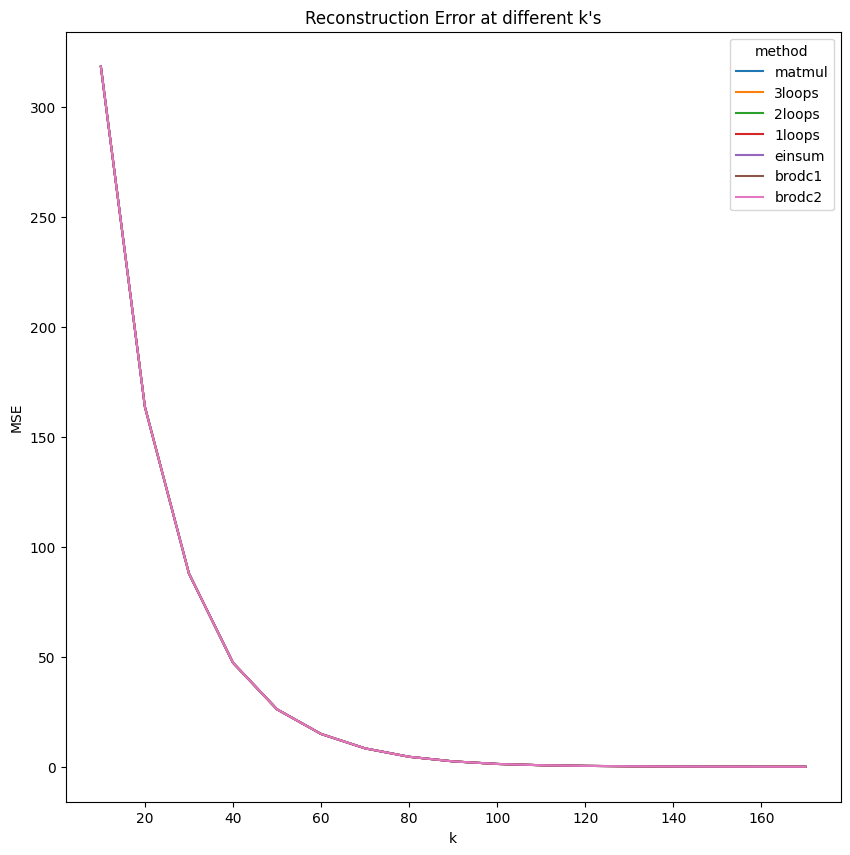

In [67]:
### BEGIN SOLUTION
import pandas as pd
import seaborn as sns

im = images[0]
im = im - im.min() / im.max() - im.min()  # normalize image
u, s, vt = np.linalg.svd(im, full_matrices=False)

m = {}
for k in range(min(im.shape), 0, -10):
    metr = {
        "matmul": metrics.mean_squared_error(im, reconstruct_svd(u, s, vt, k)),
        "3loops": metrics.mean_squared_error(im, reconstruct_svd_for_loops3(u, s, vt, k)),
        "2loops": metrics.mean_squared_error(im, reconstruct_svd_for_loops2(u, s, vt, k)),
        "1loops": metrics.mean_squared_error(im, reconstruct_svd_for_loops1(u, s, vt, k)),
        "einsum": metrics.mean_squared_error(im, reconstruct_svd_einsum1(u, s, vt, k)),
        "brodc1": metrics.mean_squared_error(im, reconstruct_svd_broadcast1(u, s, vt, k)),
        "brodc2": metrics.mean_squared_error(im, reconstruct_svd_broadcast2(u, s, vt, k))
    }
    m[k] = metr

m = pd.DataFrame.from_dict(m)
m =  m.T.reset_index(names="k")
m = pd.melt(m, "k", var_name="method", value_name="MSE")

plt.figure(figsize=(10,10))
sns.lineplot(m, x="k", y="MSE", hue="method")
plt.title("Reconstruction Error at different k's")
plt.show()

### END SOLUTION

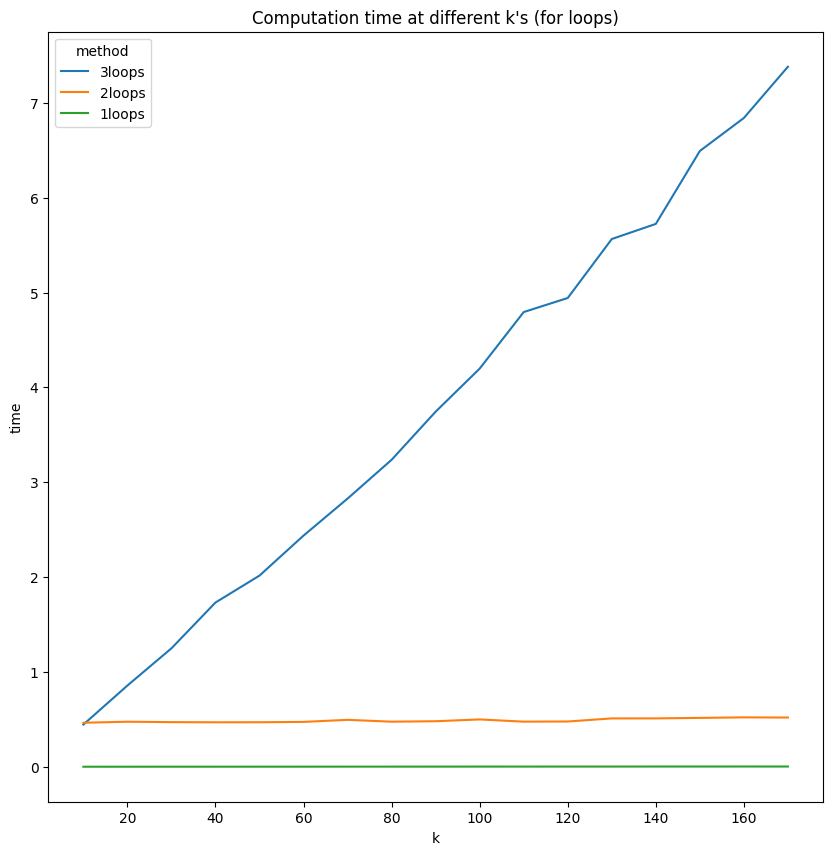

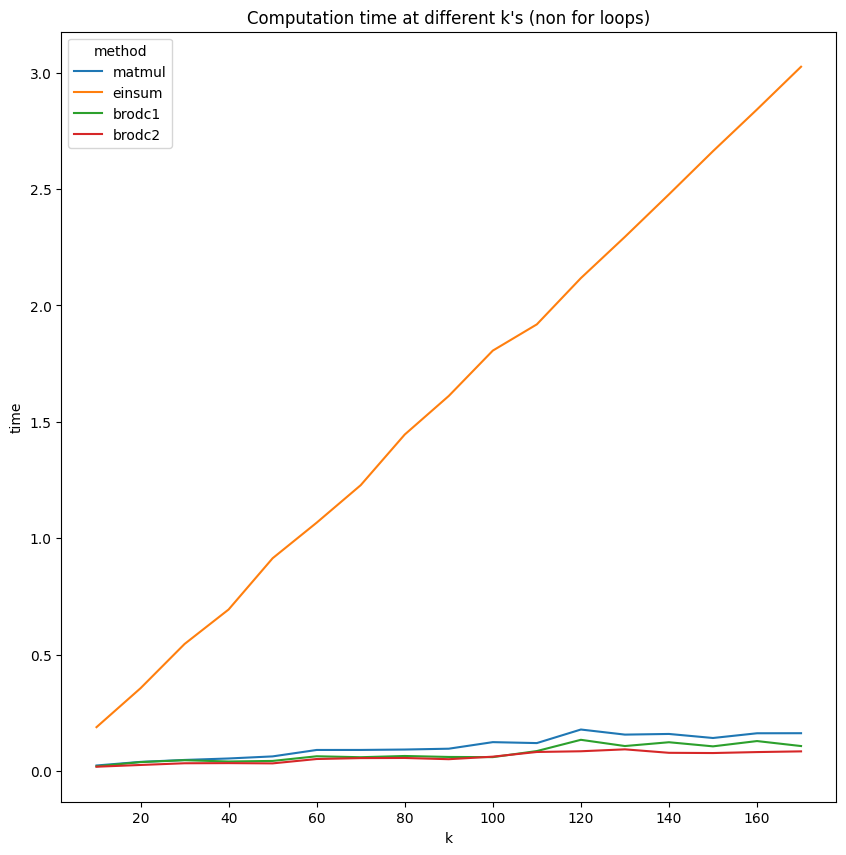

In [77]:
### BEGIN SOLUTION

from timeit import timeit

im = images[0]
im = im - im.min() / im.max() - im.min()  # normalize image
u, s, vt = np.linalg.svd(im, full_matrices=False)

m = {}
for k in range(min(im.shape), 0, -10):
    metr = {
        "matmul": timeit("reconstruct_svd(u, s, vt, k)", number=1000, globals=globals()),
        "3loops": timeit("reconstruct_svd_for_loops3(u, s, vt, k)", number=5, globals=globals()),
        "2loops": timeit("reconstruct_svd_for_loops2(u, s, vt, k)", number=5, globals=globals()),
        "1loops": timeit("reconstruct_svd_for_loops1(u, s, vt, k)", number=5, globals=globals()),
        "einsum": timeit("reconstruct_svd_einsum1(u, s, vt, k)", number=1000, globals=globals()),
        "brodc1": timeit("reconstruct_svd_broadcast1(u, s, vt, k)", number=1000, globals=globals()),
        "brodc2": timeit("reconstruct_svd_broadcast2(u, s, vt, k)", number=1000, globals=globals())
    }
    m[k] = metr

m = pd.DataFrame.from_dict(m)
m =  m.T.reset_index(names="k")
m = pd.melt(m, "k", var_name="method", value_name="time")

plt.figure(figsize=(10,10))
sns.lineplot(m[m.method.isin(['3loops', '2loops', '1loops'])], x="k", y="time", hue="method")
plt.title("Computation time at different k's (for loops)")
plt.show()

plt.figure(figsize=(10,10))
sns.lineplot(m[m.method.isin(['brodc1', 'brodc2', 'einsum', 'matmul'])], x="k", y="time", hue="method")
plt.title("Computation time at different k's (non for loops)")
plt.show()

### END SOLUTION

#### 2.5 Interpretation der Resultate

Welche der Implementierungen war am schnellsten? Was waren deine Beobachtungen während  der Implementierung? Wo können solche Optimierungen sonst noch eingesetzt werden? Diskutiere in ca. 150-200 Wörtern.

<font color='blue'>Antwort hier eingeben</font>

### 3 Parallelisierung mittels Numba

Implementiere nun eine möglichst schnelle Rekonstruktionsvariante des SVDs mittels Numba. Ist es möglich, den Code mit Numba zu beschleunigen? Führe dazu eine Diagnostik aus. Wenn ja, was ist der Speedup-Faktor und welche(r) Teil(e) konnte(n) parallelisiert werden? Falls nein, was sind die Gründe, weshalb es sich nicht parallelisieren lässt? Lassen sich verschachtelte Schleifen parallelisieren? Warum? Diskutiere in ca. 150-200 Wörtern, wann und warum sich Numba für die Parallelisierung eignet - anhand deines Beispiels.

Beachte:
* Beim ersten Mal Ausführen des Codes wird die Zeit des Kompilierens mit eingerechnet.
* Numba eignet sich gut für For-Schleifen

In [81]:
from numba import njit, float64, int64, prange

@njit(float64[:,:](float64[:,:], float64[:], float64[:,:], int64), parallel=True)
def reconstruct_svd_numba(u, s, vt, k):
    """SVD reconstruction for k components using numba
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Output:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """ 

    if k is None:
        k = min(u.shape[0], vt.shape[0])

    reco = np.zeros((u.shape[0], vt.shape[0]))

    for m in prange(u.shape[0]):
        for n in prange(vt.shape[0]):
            element = 0
            for p in prange(k):
                element += u[m, p]*s[p]*vt[p, n]

            reco[m, n] = element
            
    ### END SOLUTION

    return reco


In [84]:
### BEGIN SOLUTION
reconstruct_svd_numba(u, s, vt, 10)
### END SOLUTION

array([[-8.15810784e-04,  6.45236379e-04,  1.58762238e-03, ...,
         7.01222629e-03,  3.18587875e-03,  6.03249121e-03],
       [ 1.69005232e-03,  1.09520152e-03,  9.81626663e-04, ...,
         2.24442417e-03,  1.76083823e-03,  2.10801606e-03],
       [ 4.41905996e-03,  2.53291650e-03,  2.13196899e-03, ...,
         4.71747480e-03,  3.10865397e-03,  4.12141846e-03],
       ...,
       [ 1.23483124e+00,  9.03061408e-01,  7.28989037e-01, ...,
         1.87676222e-01, -4.89820997e-01, -6.67226024e-01],
       [ 1.26715074e+00,  9.31121480e-01,  7.83405796e-01, ...,
         2.87615265e-01, -4.03203155e-01, -6.15029520e-01],
       [ 1.22284750e+00,  9.81197987e-01,  8.44233269e-01, ...,
         3.05652839e-01, -2.18687821e-01, -4.65843568e-01]])

<font color='blue'>Antwort hier eingeben</font>

### 4 Parallelisierung mit Threads

Als nächstes Parallelisieren wir die Rekonstruktion der SVD zerlegten Matrizen mittels unterschiedlichen Thread-Varianten.

Links:
* Threading in Python ([Videokurs](https://realpython.com/courses/threading-python/), [Blogartikel](https://realpython.com/intro-to-python-threading/), [Quiz](https://realpython.com/quizzes/python-threading/)), RealPython
* https://github.com/eth-cscs/PythonHPC/tree/master/intro
* Slides vom Kurs kvanc zum Thema IPC mittels Python

#### 4.1 Einzelne Threads auf einer CPU

Implementiere eine Funktion, welche ein Rekonstruktionsschritt in Thread rekonstruiert. Wähle selbst welchen Schritt du mittels Threading implementierst. Verwende dabei geeignete Lock-Mechanismen. Verwende vor und nach den Lock-Mechanismen geeignete Print/Log-Statements. Validiere dein Ergebnis der Rekonstruktion indem du mehrere Threads für einzelne Rekonstruktionsschritte aufruftst.

In [ ]:
### BEGIN SOLUTION



### END SOLUTION


In [ ]:
### BEGIN SOLUTION



### END SOLUTION

#### 4.2 Bonus: Thread-Pool-Executor

Rufe zum Vergleich die unabhängige Rekonstruktionsschritte mittels eines Thread-Pool-Executors auf.

In [ ]:
### BEGIN SOLUTION

### END SOLUTION

#### 4.3 Bonus: Threads auf mehreren CPUs

Verwende anstelle von Threading Multiprocessing damit die Threads auf mehrere CPUs verteilt werden.

Links:
* Concurrency [Blog](https://realpython.com/python-concurrency/), [Quiz](https://realpython.com/quizzes/python-concurrency/), RealPython


In [ ]:
### BEGIN SOLUTION

### END SOLUTION

#### 4.4 Analyse

1. Macht es in diesem Beispiel Sinn Threads zu benutzen? Wann ist es sinnvoll Threads zu benutzen? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>Antwort hier eingeben</font>

2. Könnten in diesem Beispiel auch andere Code-Teile auf mehreren Threads aufgerufen werden? Welche würden sich eignen? Welche nicht? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>Antwort hier eingeben</font>

3. Was sind die Unterschiede (auch bzgl. Leistung) der manuellen Ausführung des Threadings vs. dem Benutzen eines Thread-Pool-Executors oder von Multiprocessing?

<font color='blue'>Antwort hier eingeben</font>